# Setting up the Environment

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

# Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. We will need to write a query to find out which genres sell the most tracks in the USA, write up a summary of your findings, and make a recommendation for the three artists whose albums we should purchase for the store.



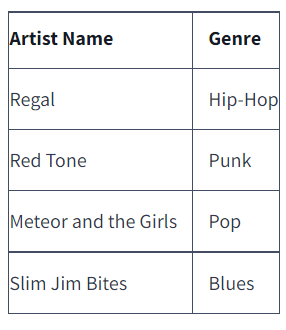

In [2]:
%%sql
WITH m AS (SELECT *, g.name genrename
           FROM invoice AS inv
            LEFT JOIN invoice_line il ON il.invoice_id=inv.invoice_id
            LEFT JOIN track tr ON tr.track_id=il.track_id
            LEFT JOIN genre g ON g.genre_id=tr.genre_id
          WHERE billing_country='USA')

SELECT genrename, 
    COUNT(track_id) AS tracks_sold,
    ROUND((COUNT(track_id)/(SELECT CAST(COUNT(*) AS FLOAT)
          FROM m))*100,2) percentage_sold
    FROM m
    GROUP BY genrename
    ORDER BY tracks_sold DESC

Done.


genrename,tracks_sold,percentage_sold
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.8
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Latin,22,2.09
Pop,22,2.09
Hip Hop/Rap,20,1.9
Jazz,14,1.33


Therefore, the record label should focus on employing the album 'Red Tone' into the store. This is because that artist is within the 'Punk' genre, which is the second most popular genre in terms of tracks sold across the United States.

Furthermore, the other artists don't seem as attractive as there is a substantial decrease in genre popularity past 'Metal', as displayed above. However, the next best two genres within the list is Blues and Pop, so we would choose Meteor and the Grils alongside Sim Jim Bites.

# Analyzing Employee Sales Performance

In [3]:
%%sql 
WITH sal AS (SELECT * 
            FROM employee em 
            LEFT JOIN customer cr ON cr.support_rep_id=em.employee_id
            LEFT JOIN invoice io ON io.customer_id=cr.customer_id
            WHERE title='Sales Support Agent')
SELECT first_name || ' ' || last_name employee_name, 
ROUND(SUM(total)) sales_total, 
COUNT(invoice_id) number_of_tracks_sold,
hire_date
FROM sal
GROUP BY support_rep_id 
ORDER BY sales_total DESC

Done.


employee_name,sales_total,number_of_tracks_sold,hire_date
Jane Peacock,1732.0,212,2017-04-01 00:00:00
Margaret Park,1584.0,214,2017-05-03 00:00:00
Steve Johnson,1394.0,188,2017-10-17 00:00:00


We can see that Jane Peacock has generated the most revenue for the company in terms of USD. However, Margaret Park has sold the the most amount of tracks. This therefore means the tracks that Jane has sold were at a higher price than Margaret's sales.

Because the sales USD difference is substantial while the number of tracks sold isn't, we can conclude that Jane Peacock is the most valuable employee at the company.

We can also see that Jane Peacock has been at the company the longest, which shows why. Furthermore, Steve Johnson has been at the company the least by a substantial amount, showing why he had lower number of tracks sold. 

# Analyzing Sales by Country

We will be analyzing the number of distinct customers from each country. We will also calculate the total amount of sales a country brings in, the average sales per customer (average amount of sales a customer brings from XYZ country), and the average order (since a single customer can have multiple individual orders according to 'invoice'). 

We will also categorize countries with one distinct customer in the 'Other section' for concision.

In [4]:
%%sql
WITH ifix AS (SELECT *, SUM(total) total_cust, AVG(total) avg_order
                  FROM invoice 
                  GROUP BY customer_id),
    comb AS (SELECT *
         FROM customer c 
         LEFT JOIN ifix i ON i.customer_id=c.customer_id),
    fin AS (SELECT *, 
                  COUNT(DISTINCT(customer_id)) num_customers,
                  SUM(total_cust) total_sales, 
                  AVG(total_cust) average_sales_per_customer, 
                  (SUM(total_cust)/(SELECT COUNT(billing_country) 
                                    FROM invoice 
                                    WHERE billing_country=comb.country)) average_order
              FROM comb
              GROUP BY country),
    final AS (SELECT *, SUM(num_customers) final_cust_number,
            CASE
                WHEN num_customers=1 THEN 0 
                ELSE 1
                END AS numcat,
            CASE
                WHEN num_customers=1 THEN 'Other'
                ELSE country
                END AS country_final
            FROM fin
            GROUP BY country_final
            ORDER BY numcat DESC, final_cust_number DESC
            )

SELECT country_final, 
final_cust_number number_of_customers, 
ROUND(total_sales,2) total_sales, ROUND(average_sales_per_customer,2) average_sales_per_customer, 
ROUND(average_order,2) average_order
FROM final

Done.


country_final,number_of_customers,total_sales,average_sales_per_customer,average_order
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
United Kingdom,3,245.52,81.84,8.77
Czech Republic,2,273.24,136.62,9.11
India,2,183.15,91.57,8.72
Portugal,2,185.13,92.56,6.38
Other,15,75.24,75.24,7.52


# Albums vs Individual Tracks

Within this section, we will categorizing purchases as full album purchases or simply individual tracks. There are two things we need to consider. People who buy a singular track can be classified as an album purchase as there is only one 'album' contained, and people who buy a album will only have one distinct album in the invoice, we need to differentiate between the two:

In [159]:
%%sql
WITH comb AS (SELECT il.invoice_id, 
              il.invoice_line_id, 
              t.track_id, t.album_id, 
              COUNT(t.track_id) num_tracks, 
              COUNT(DISTINCT(t.album_id)) distinct_album
              FROM invoice i
              INNER JOIN invoice_line il ON il.invoice_id=i.invoice_id
              INNER JOIN track t ON t.track_id=il.track_id
              GROUP BY il.invoice_id),
    album_track_count AS (SELECT album_id, COUNT(track_id) track_count
                          FROM track 
                          GROUP BY album_id),
    final AS (SELECT *, 
              COUNT(*) num_count, 
              ROUND((CAST(COUNT(*) AS FLOAT)/(SELECT COUNT(*) FROM comb))*100,2) percentage,
             CASE
                 WHEN distinct_album=1 AND num_tracks=
                 THEN 'Albums'
                 ELSE 'Singles'
                 END AS 'category'
            FROM comb
            INNER JOIN album_track_count AS al ON al.album_id=comb.album_id
            GROUP BY category)

SELECT category, num_count, percentage
FROM final

Done.


category,num_count,percentage
Albums,133,21.66
Singles,481,78.34
